## **Predicting Disease Spread: Feature Engineering**

### **Imports**

In [46]:
import sys
import os

import numpy as np
import pandas as pd

sys.path.append(os.path.abspath(".."))
from src.data_setup import load_data, split_cities
from src.visualization import (
    missing_data_percentage_by_city,
    visualize_differences_in_dataframes,
)
from src.feature_engineering import (
    add_last_train_rows_to_test,
    NAImputer,
    ColumnAggregator,
    create_pipeline,
    NewFeaturesAdder
)

### **Datasets loading**

Train

In [2]:
features_train, labels_train = load_data(train=True)
sj_features_train, iq_features_train = split_cities(features_train)
sj_labels_train, iq_labels_train = split_cities(labels_train)

Test

In [3]:
features_test, labels_test = load_data(train=False)
sj_features_test, iq_features_test = split_cities(features_test)

In [4]:
sj_features_train.head(n=10)

week_start_date   ndvi_ne   ndvi_nw   ndvi_se   ndvi_sw  \
year weekofyear                                                           
1990 18              1990-04-30  0.122600  0.103725  0.198483  0.177617   
     19              1990-05-07  0.169900  0.142175  0.162357  0.155486   
     20              1990-05-14  0.032250  0.172967  0.157200  0.170843   
     21              1990-05-21  0.128633  0.245067  0.227557  0.235886   
     22              1990-05-28  0.196200  0.262200  0.251200  0.247340   
     23              1990-06-04       NaN  0.174850  0.254314  0.181743   
     24              1990-06-11  0.112900  0.092800  0.205071  0.210271   
     25              1990-06-18  0.072500  0.072500  0.151471  0.133029   
     26              1990-06-25  0.102450  0.146175  0.125571  0.123600   
     27              1990-07-02       NaN  0.121550  0.160683  0.202567   

                 precipitation_amt_mm  reanalysis_air_temp_k  \
year weekofyear                                                
1990 18                         12.42             297.572857   
     19                         22.82             298.211429   
     20                         34.54             298.781429   
     21                         15.36             298.987143   
     22                          7.52             299.518571   
     23                          9.58             299.630000   
     24                          3.48             299.207143   
     25                        151.12             299.591429   
     26                         19.32             299.578571   
     27                         14.41             300.154286   

                 reanalysis_avg_temp_k  reanalysis_dew_point_temp_k  \
year weekofyear                                                       
1990 18                     297.742857                   292.414286   
     19                     298.442857                   293.951429   
     20                     298.878571                   295.434286   
     21                     299.228571                   295.310000   
     22                     299.664286                   295.821429   
     23                     299.764286                   295.851429   
     24                     299.221429                   295.865714   
     25                     299.528571                   296.531429   
     26                     299.557143                   296.378571   
     27                     300.278571                   296.651429   

                 reanalysis_max_air_temp_k  ...  \
year weekofyear                             ...   
1990 18                              299.8  ...   
     19                              300.9  ...   
     20                              300.5  ...   
     21                              301.4  ...   
     22                              301.9  ...   
     23                              302.4  ...   
     24                              301.3  ...   
     25                              300.6  ...   
     26                              302.1  ...   
     27                              302.3  ...   

                 reanalysis_precip_amt_kg_per_m2  \
year weekofyear                                    
1990 18                                    32.00   
     19                                    17.94   
     20                                    26.10   
     21                                    13.90   
     22                                    12.20   
     23                                    26.49   
     24                                    38.60   
     25                                    30.00   
     26                                    37.51   
     27                                    28.40   

                 reanalysis_relative_humidity_percent  \
year weekofyear                                         
1990 18                                     73.365714   
     19                                     77.368571   
     20                    

### **Tasks completed**
- [EDA] target distribution
- [EDA] spearman correlation
1. Imputation using methods: linear, 
2. Adding last rows from train set to test set
3. New features: random modifications of existing ones (addition, multiplication)
4. Feature modification: aggregation of vegetation indexes
5. New feature: total_cases (target) from previous weeks

I this notebook, we present example usage and reasons of the modifications to the dataset.

### **1. Imputations**

In [5]:
imputer = NAImputer(method="linear")
sj_features_train_imputed = imputer.transform(sj_features_train)
iq_features_train_imputed = imputer.transform(iq_features_train)

In [6]:
visualize_differences_in_dataframes(
    columns=["ndvi_ne"],
    rows=[5, 8, 9],
    data_frame_1=sj_features_train,
    data_frame_2=sj_features_train_imputed,
    name_1="with NAs",
    name_2="Imputed",
)

╒══════════════════════╤════════════════════╤═══════════════════╕
│ Year, Week of Year   │   ndvi_ne with NAs │   ndvi_ne Imputed │
╞══════════════════════╪════════════════════╪═══════════════════╡
│ (1990, 23)           │          nan       │          0.15455  │
├──────────────────────┼────────────────────┼───────────────────┤
│ (1990, 26)           │            0.10245 │          0.10245  │
├──────────────────────┼────────────────────┼───────────────────┤
│ (1990, 27)           │          nan       │          0.147663 │
╘══════════════════════╧════════════════════╧═══════════════════╛


In [7]:
visualize_differences_in_dataframes(
    columns=["station_avg_temp_c"],
    rows=[44, 45, 46, 51, 95],
    data_frame_1=iq_features_train,
    data_frame_2=iq_features_train_imputed,
    name_1="with NAs",
    name_2="Imputed",
)

╒══════════════════════╤═══════════════════════════════╤══════════════════════════════╕
│ Year, Week of Year   │   station_avg_temp_c with NAs │   station_avg_temp_c Imputed │
╞══════════════════════╪═══════════════════════════════╪══════════════════════════════╡
│ (2001, 19)           │                       26.6    │                      26.6    │
├──────────────────────┼───────────────────────────────┼──────────────────────────────┤
│ (2001, 20)           │                      nan      │                      27.0167 │
├──────────────────────┼───────────────────────────────┼──────────────────────────────┤
│ (2001, 21)           │                       27.4333 │                      27.4333 │
├──────────────────────┼───────────────────────────────┼──────────────────────────────┤
│ (2001, 26)           │                      nan      │                      26.45   │
├──────────────────────┼───────────────────────────────┼──────────────────────────────┤
│ (2002, 18)           │        

Let's verify, if there are no NAs in the dataset.

a. Train

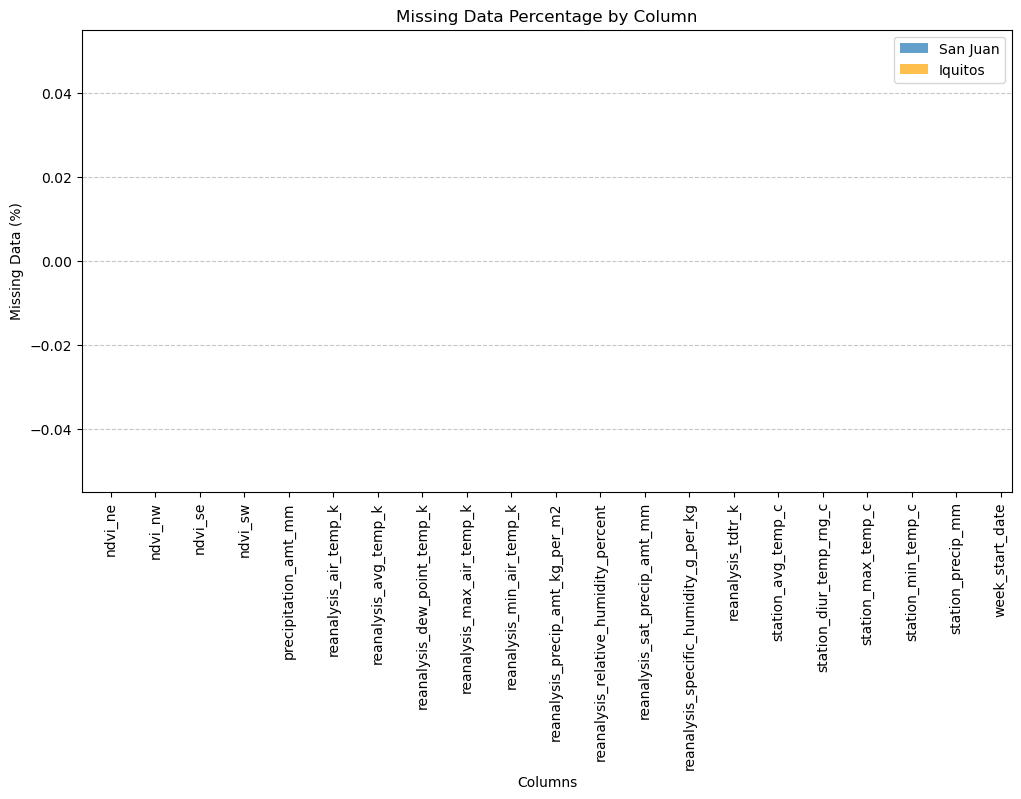

In [8]:
missing_data_percentage_by_city(sj_features_train_imputed, iq_features_train_imputed)

b. Test before

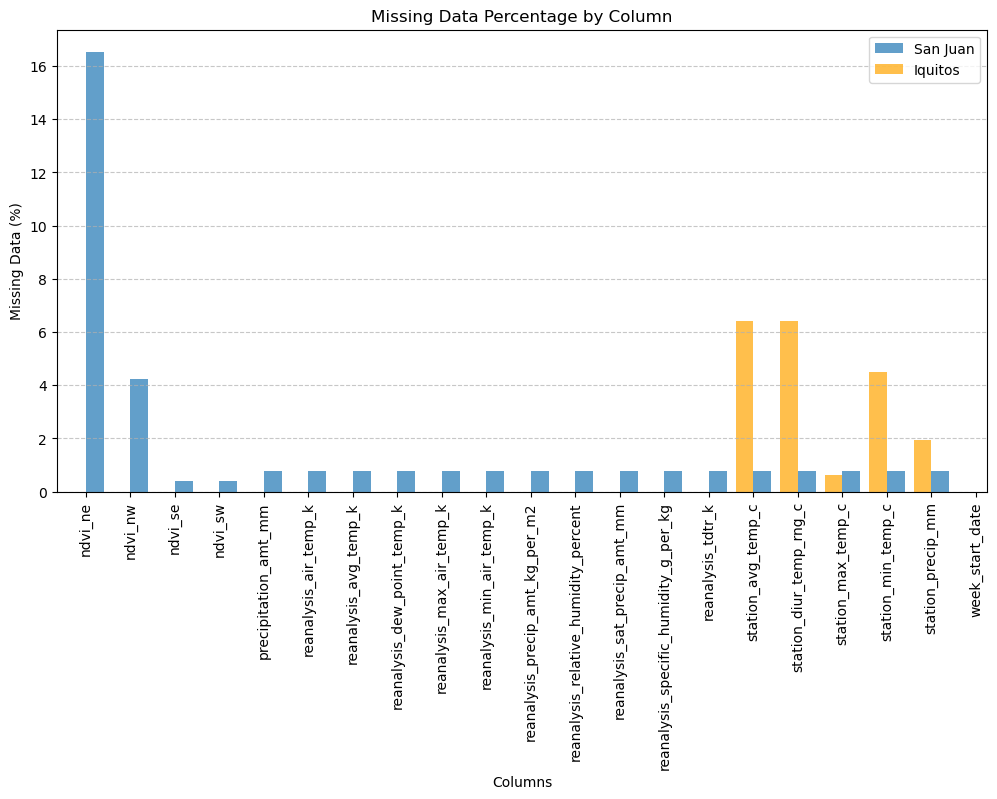

In [9]:
missing_data_percentage_by_city(sj_features_test, iq_features_test)

b. Test after

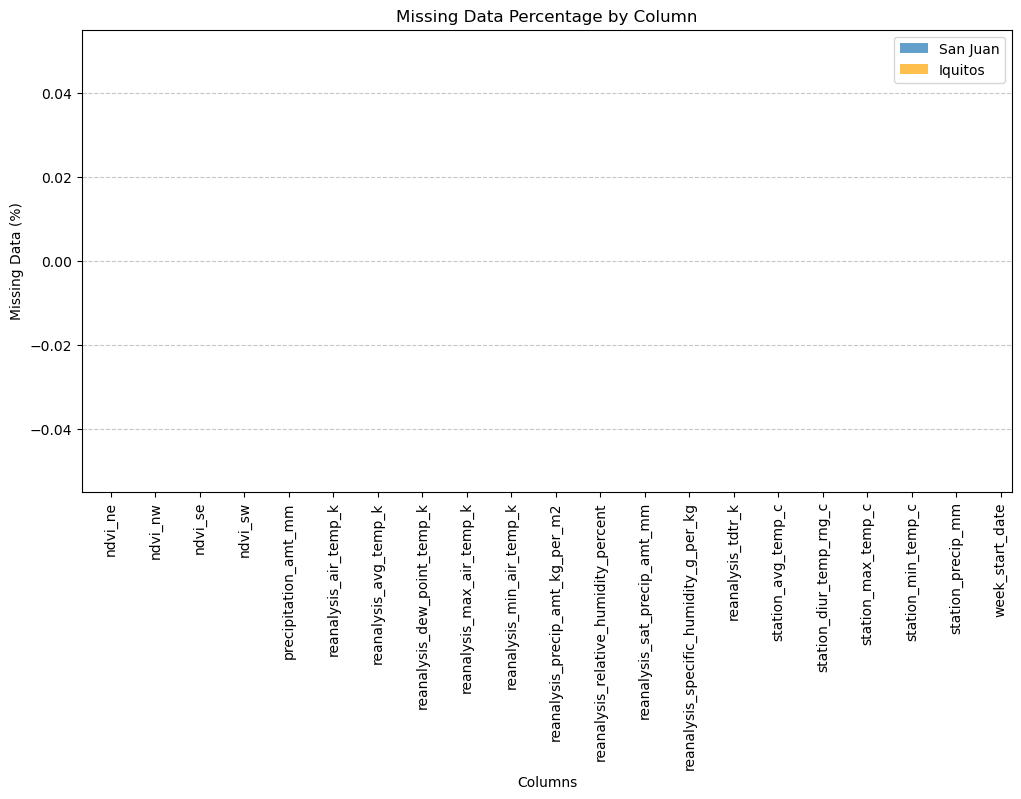

In [10]:
sj_features_test_imputed = imputer.transform(sj_features_test)
iq_features_test_imputed = imputer.transform(iq_features_test)
missing_data_percentage_by_city(sj_features_test_imputed, iq_features_test_imputed)

### **2. Last rows from train dataset to test dataset**

In [11]:
sj_features_test_added_rows, sj_labels_test_added_rows = add_last_train_rows_to_test(
    train_x=sj_features_train,
    test_x=sj_features_test,
    train_y=sj_labels_train,
    label="total_cases",
    add_k_rows=3,
)

In [12]:
sj_features_test.head(4)

week_start_date  ndvi_ne   ndvi_nw   ndvi_se   ndvi_sw  \
year weekofyear                                                          
2008 18              2008-04-29  -0.0189 -0.018900  0.102729  0.091200   
     19              2008-05-06  -0.0180 -0.012400  0.082043  0.072314   
     20              2008-05-13  -0.0015       NaN  0.151083  0.091529   
     21              2008-05-20      NaN -0.019867  0.124329  0.125686   

                 precipitation_amt_mm  reanalysis_air_temp_k  \
year weekofyear                                                
2008 18                         78.60             298.492857   
     19                         12.56             298.475714   
     20                          3.66             299.455714   
     21                          0.00             299.690000   

                 reanalysis_avg_temp_k  reanalysis_dew_point_temp_k  \
year weekofyear                                                       
2008 18                     298.550000                   294.527143   
     19                     298.557143                   294.395714   
     20                     299.357143                   295.308571   
     21                     299.728571                   294.402857   

                 reanalysis_max_air_temp_k  ...  \
year weekofyear                             ...   
2008 18                              301.1  ...   
     19                              300.8  ...   
     20                              302.2  ...   
     21                              303.0  ...   

                 reanalysis_precip_amt_kg_per_m2  \
year weekofyear                                    
2008 18                                    25.37   
     19                                    21.83   
     20                                     4.12   
     21                                     2.20   

                 reanalysis_relative_humidity_percent  \
year weekofyear                                         
2008 18                                     78.781429   
     19                                     78.230000   
     20                                     78.270000   
     21                                     73.015714   

                 reanalysis_sat_precip_amt_mm  \
year weekofyear                                 
2008 18                                 78.60   
     19                                 12.56   
     20                                  3.66   
     21                                  0.00   

                 reanalysis_specific_humidity_g_per_kg  reanalysis_tdtr_k  \
year weekofyear                                                             
2008 18                                      15.918571           3.128571   
     19                                      15.791429           2.571429   
     20                                      16.674286           4.428571   
     21                                      15.775714           4.342857   

                 station_avg_temp_c  station_diur_temp_rng_c  \
year weekofyear                                                
2008 18                   26.528571                 7.057143   
     19                   26.071429                 5.557143   
     20                   27.928571                 7.785714   
     21                   28.057143                 6.271429   

                 station_max_temp_c  station_min_temp_c  station_precip_mm  
year weekofyear                                                             
2008 18                        33.3                21.7               75.2  
     19                        30.0                22.2               34.3  
     20                        32.8                22.8                3.0  
     21                        33.3                24.4                0.3  

[4 rows x 21 columns]

In [13]:
sj_features_test_added_rows.head(4)

week_start_date  ndvi_ne   ndvi_nw   ndvi_se   ndvi_sw  \
year weekofyear                                                          
2008 15              2008-04-08  -0.1552 -0.052750  0.137757  0.141214   
     16              2008-04-15   0.0018       NaN  0.203900  0.209843   
     17              2008-04-22  -0.0370 -0.010367  0.077314  0.090586   
     18              2008-04-29  -0.0189 -0.018900  0.102729  0.091200   

                 precipitation_amt_mm  reanalysis_air_temp_k  \
year weekofyear                                                
2008 15                         16.96             297.460000   
     16                          0.00             297.630000   
     17                          0.00             298.672857   
     18                         78.60             298.492857   

                 reanalysis_avg_temp_k  reanalysis_dew_point_temp_k  \
year weekofyear                                                       
2008 15                     297.564286                   292.732857   
     16                     297.778571                   292.274286   
     17                     298.692857                   294.280000   
     18                     298.550000                   294.527143   

                 reanalysis_max_air_temp_k  ...  \
year weekofyear                             ...   
2008 15                              299.4  ...   
     16                              299.7  ...   
     17                              300.9  ...   
     18                              301.1  ...   

                 reanalysis_precip_amt_kg_per_m2  \
year weekofyear                                    
2008 15                                    35.00   
     16                                     4.82   
     17                                     2.17   
     18                                    25.37   

                 reanalysis_relative_humidity_percent  \
year weekofyear                                         
2008 15                                     75.027143   
     16                                     72.285714   
     17                                     76.960000   
     18                                     78.781429   

                 reanalysis_sat_precip_amt_mm  \
year weekofyear                                 
2008 15                                 16.96   
     16                                  0.00   
     17                                  0.00   
     18                                 78.60   

                 reanalysis_specific_humidity_g_per_kg  reanalysis_tdtr_k  \
year weekofyear                                                             
2008 15                                      14.184286           2.185714   
     16                                      13.858571           2.785714   
     17                                      15.671429           3.957143   
     18                                      15.918571           3.128571   

                 station_avg_temp_c  station_diur_temp_rng_c  \
year weekofyear                                                
2008 15                   25.000000                 5.714286   
     16                   25.314286                 6.242857   
     17                   27.042857                 7.514286   
     18                   26.528571                 7.057143   

                 station_max_temp_c  station_min_temp_c  station_precip_mm  
year weekofyear                                                             
2008 15                        29.4                21.7               30.7  
     16                        29.4                21.7               11.2  
     17                        31.7                23.3                0.3  
     18                        33.3                21.7               75.2  

[4 rows x 21 columns]

3 rows added: week 15, 16, 17

And for labels df (total_cases, target)

In [14]:
sj_labels_train.tail(4)

total_cases
year weekofyear             
2008 14                    3
     15                    1
     16                    3
     17                    5

In [15]:
sj_labels_test_added_rows.head(6)

total_cases
year weekofyear             
2008 15                    1
     16                    3
     17                    5
     18                    0
     19                    0
     20                    0

### **3. New features as modifications of existing ones**

In [16]:
new_features_adder_sj = NewFeaturesAdder(top_n = 10)
new_features_adder_iq = NewFeaturesAdder(top_n = 10)


In [17]:
new_features_adder_sj = new_features_adder_sj.fit(X = sj_features_train_imputed,
                                                  y = sj_labels_train)

In [18]:
sj_features_train_imputed_new_features = new_features_adder_sj.transform(X = sj_features_train_imputed)

In [19]:
sj_features_test_imputed_new_features = new_features_adder_sj.transform(X = sj_features_test_imputed)

In [20]:
new_features_adder_iq = new_features_adder_iq.fit(X = iq_features_train_imputed,
                                                  y = iq_labels_train)

In [21]:
iq_features_train_imputed_new_features = new_features_adder_iq.transform(X = iq_features_train_imputed)

In [22]:
iq_features_test_imputed_new_features = new_features_adder_iq.transform(X = iq_features_test_imputed)

In [23]:
print(f"Number of columns in dataset before adding new features: {len(sj_features_train.columns)} \n\
and after: {len(sj_features_test_imputed_new_features)}.")

Number of columns in dataset before adding new features: 21 
and after: 260.


### **4. Aggregation of `ndvi_` (vegetation indexes) columns**

In [24]:
aggregator = ColumnAggregator(
    columns=["ndvi_ne", "ndvi_nw", "ndvi_se", "ndvi_sw"], col_name="ndvi"
)

In [25]:
sj_features_train_imputed_aggr = aggregator.transform(sj_features_train_imputed)

In [26]:
print(f"Number of columns in dataset before aggregations: {len(sj_features_train_imputed.columns)} \n\
and after: {len(sj_features_train_imputed_aggr.columns)}.")

Number of columns in dataset before aggregations: 21 
and after: 22.


### **5. Previous total_cases as new feature**

In [27]:
from src.feature_engineering import PrevCasesAdder

prev_cases_adder = PrevCasesAdder(k_prev=3)
prev_cases_adder.fit(sj_features_train, sj_labels_train)

PrevCasesAdder(k_prev=3)

In [28]:
prev_cases_adder.transform(sj_features_train, sj_labels_train)[["1_prev_cases", "2_prev_cases", "3_prev_cases"]]

1_prev_cases  2_prev_cases  3_prev_cases
year weekofyear                                          
1990 18                     4             4             4
     19                     4             4             4
     20                     5             4             4
     21                     4             5             4
     22                     3             4             5
...                       ...           ...           ...
2008 13                     3             2             1
     14                     4             3             2
     15                     3             4             3
     16                     1             3             4
     17                     3             1             3

[936 rows x 3 columns]

dla porownania labels

In [29]:
sj_labels_train

total_cases
year weekofyear             
1990 18                    4
     19                    5
     20                    4
     21                    3
     22                    6
...                      ...
2008 13                    4
     14                    3
     15                    1
     16                    3
     17                    5

[936 rows x 1 columns]

### **Final pipeline - example**

Everything (NAImputer, NewFeaturesAdder, PrevCasesAdder, MinMaxScaler) in pipeline.

In [30]:
pipeline = create_pipeline(imputation_method="bfill",
                           top_n=10,
                           scaling_method="minmax",
                           corr_method="pearson",
                           k_prev=3)

Ten pipeline dziala na numeryczne zmienne tylko (bo scaler jest), czyli wszystkie oprocz weekstartdate.
Czy my w ogole chcemy zostawiac te kolumne?

In [40]:
sj_features_train_num = sj_features_train.drop(columns=['week_start_date'])
sj_features_test_num = sj_features_test.drop(columns=['week_start_date'])


In [41]:
pipeline.fit(X=sj_features_train_num, y=sj_labels_train)

Pipeline(steps=[('imputer', NAImputer(method='bfill')),
                ('features_adder', NewFeaturesAdder(top_n=10)),
                ('k_prev_adder', PrevCasesAdder(k_prev=3)),
                ('scaler', MinMaxScaler())])

In [42]:
sj_features_train_transformed = pipeline.transform(sj_features_train_num)

### **Example model**

In [70]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(random_state=42)
model.fit(X = sj_features_train_transformed,
          y = sj_labels_train)

y_pred = model.predict(X = sj_features_train_transformed)

/Users/gasparsekula/anaconda3/lib/python3.12/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


In [71]:
y = sj_labels_train["total_cases"]
np.mean( np.abs(y_pred - y) )

3.035

In [78]:
model.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 1.0,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

Let's tune its hyperperameters.

In [49]:
PARAM_GRID = {
        "n_estimators": [100, 200, 300],
        "max_depth": [None, 5, 10, 15, 20],
        "min_samples_split": [2, 5, 10],
        "min_samples_leaf": [1, 2, 4],
        "max_features": ["sqrt", "log2", None],
        "bootstrap": [True, False],
        "random_state": [42],
    }

In [75]:
from sklearn.model_selection import RandomizedSearchCV

search = RandomizedSearchCV(model,
                            PARAM_GRID,
                            scoring='neg_mean_absolute_error',
                            n_iter = 50,
                            cv = 5, 
                            random_state=42,
                            verbose = False,
                            error_score= 'raise')

search.fit(X = sj_features_train_transformed,
           y = sj_labels_train)

/Users/gasparsekula/anaconda3/lib/python3.12/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/gasparsekula/anaconda3/lib/python3.12/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/gasparsekula/anaconda3/lib/python3.12/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/gasparsekula/anaconda3/lib/python3.12/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array

RandomizedSearchCV(cv=5, error_score='raise',
                   estimator=RandomForestRegressor(random_state=42), n_iter=50,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [None, 5, 10, 15, 20],
                                        'max_features': ['sqrt', 'log2', None],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 200, 300],
                                        'random_state': [42]},
                   random_state=42, scoring='neg_mean_absolute_error',
                   verbose=False)

In [76]:
y_pred_2 = search.predict(X = sj_features_train_transformed)
np.mean( np.abs(y_pred_2 - y) )

6.220528644749263

XD

In [79]:
search.get_params()

{'cv': 5,
 'error_score': 'raise',
 'estimator__bootstrap': True,
 'estimator__ccp_alpha': 0.0,
 'estimator__criterion': 'squared_error',
 'estimator__max_depth': None,
 'estimator__max_features': 1.0,
 'estimator__max_leaf_nodes': None,
 'estimator__max_samples': None,
 'estimator__min_impurity_decrease': 0.0,
 'estimator__min_samples_leaf': 1,
 'estimator__min_samples_split': 2,
 'estimator__min_weight_fraction_leaf': 0.0,
 'estimator__n_estimators': 100,
 'estimator__n_jobs': None,
 'estimator__oob_score': False,
 'estimator__random_state': 42,
 'estimator__verbose': 0,
 'estimator__warm_start': False,
 'estimator': RandomForestRegressor(random_state=42),
 'n_iter': 50,
 'n_jobs': None,
 'param_distributions': {'n_estimators': [100, 200, 300],
  'max_depth': [None, 5, 10, 15, 20],
  'min_samples_split': [2, 5, 10],
  'min_samples_leaf': [1, 2, 4],
  'max_features': ['sqrt', 'log2', None],
  'bootstrap': [True, False],
  'random_state': [42]},
 'pre_dispatch': '2*n_jobs',
 'random_st